# Data initial exploration - Torch Version
*Matthieu OLEKHNOVITCH*

## Introduction 
This notebook is dedicated to the initial exploration of the data. It is the first step of the data science process. The goal is to get a first idea of the data, to understand it and to identify the main challenges.

In [39]:
import numpy as np
import pandas as pd
import networkx as nx
import json
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import os

In [42]:
# ----------------- Load Training Labels -----------------#

training_label_path = 'training_labels.json'
print(os.path.dirname(os.path.abspath(training_label_path)))
try :
    labels_data = json.load(open(training_label_path))
    print(training_label_path + ' loaded')

except FileNotFoundError:
    print('File not found: ', training_label_path)


# ----------------- Load Training Data -------------------#

training_data_path = 'training/'
discussion_ids = []
for key in labels_data.keys():
    discussion_ids.append(key)

print('Number of discussions: ', len(discussion_ids))



# -------------------------------------------------------#

c:\Users\Olek\Documents\GitHub\Kaggle-competition---Extractive-Summarization-with-Discourse-Graphs
training_labels.json loaded
Number of discussions:  97


# Building a conversation graph (torch version)

Discussion ID:  IS1003d
Discussion file loaded
Number of posts:  1095
Number of labels 1095
Starting nodes:  [   0    1    1 ... 1091 1092 1091]
Number of edges:  1094
tensor([0, 0, 0,  ..., 0, 0, 0])


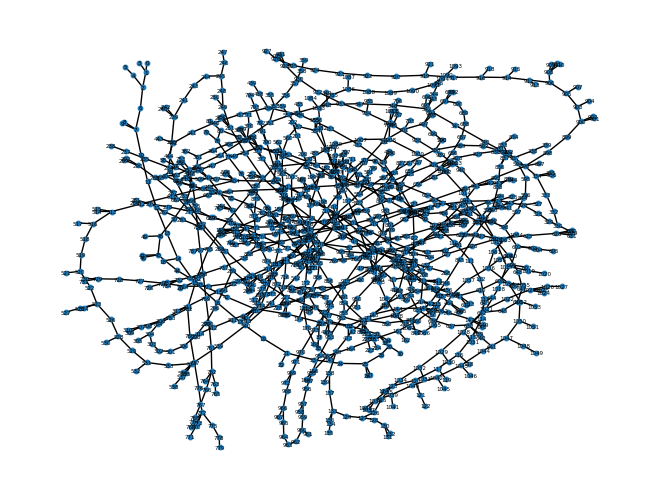

In [49]:
# ------------------ Loading Discussions ----------------#  

discussion_id = discussion_ids[0]                                  # Select a discussion

print('Discussion ID: ', discussion_id)
discussion_path = training_data_path + discussion_id + '.json'
try :
    discussion_json = json.load(open(discussion_path))
    print('Discussion file loaded')
except: 
    print('Error loading discussion file')

num_of_posts = len(discussion_json)
print('Number of posts: ', num_of_posts)

discussion_labels = torch.tensor(labels_data[discussion_id], dtype=int)
print('Number of labels', discussion_labels.shape[0])

# ----------------------Loading edges----------------------#

edges_path = training_data_path + discussion_id + '.txt'
edges = np.array(np.loadtxt(edges_path, dtype=str))
starting_nodes = (edges[:, 0]).astype(int)
ending_nodes = edges[:, 2].astype(int)
print('Starting nodes: ', starting_nodes)
print('Number of edges: ', len(edges))

# ----------------- Buidling torch graph ------------------#

nodes = torch.tensor([i for i in range(num_of_posts)], dtype=torch.long)
edge_index_directed = torch.tensor([starting_nodes, ending_nodes], dtype=torch.long)

# ----------------- Visualizing graph ---------------------#

data = Data(x=nodes, edge_index=edge_index_directed, labels_data=discussion_labels)
print(discussion_labels)
g = to_networkx(data, to_undirected=True)
nx.draw(g, node_size=10,with_labels=True, font_size=4)